### Callin Switzer
### Use nn to process sounds



In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import os
import pandas as pd
import time
import re
from datetime import datetime
import sys
import csv
import seaborn as sns
from collections import Counter
from IPython.display import Image
from scipy import signal

print(sys.version, "\n")

now = datetime.now()
print("last run on " + str(now))

3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)] 

last run on 2018-04-13 15:19:21.625210


In [2]:
import os

def windowsOrMacDirectories():
    """ Sets base directories for win or mac

       
    """
    if os.environ['COMPUTERNAME'] == 'SHEALMACLEARN':
        DropboxDirect = os.path.join("D:\Dropbox")
#     elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
#         # this excludes your current terminal "/dev/tty"
    elif sys.platform.startswith('darwin'):
        DropboxDirect = os.path.join("/Users/cswitzer/Dropbox")
    else:
        raise EnvironmentError('Unknown computer platform')
    
    baseDir = os.getcwd()
    dataDir = os.path.join(DropboxDirect, 'SonicationBehavior', 'SonBehData')
    figDir = os.path.join(DropboxDirect, 'SonicationBehavior', 'SonBehFigs')
    return baseDir, dataDir, figDir


baseDir, dataDir, figDir = windowsOrMacDirectories()
print(dataDir)

D:\Dropbox\SonicationBehavior\SonBehData


In [3]:
def readMyFile(filename):
    
    '''Read in csv 10x faster than pandas'''
    
    tmpdta = []
 
    with open(filename, newline="\n") as csvDataFile:
        csvReader = csv.reader(csvDataFile, delimiter=' ', quoting=csv.QUOTE_NONNUMERIC)
        for row in csvReader:
            tmpdta.append(row)
 
    return(pd.DataFrame(np.transpose(tmpdta)))

In [4]:
# read in dataset that was pre-classified
buzzClassDataDir = os.path.join("D:\Dropbox\SonicationBehavior\SonBehData\BuzzPartClassification")
buzzClass = pd.read_csv(os.path.join(buzzClassDataDir, 'BuzzClassifications.csv'))
print(buzzClass.shape)
buzzClass.head()

(200, 7)


,fileName,noise1,noise2,wing1,wing2,buzz1,buzz2
0,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,0,0,0,20000
1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,10000,20000,0,10000
2,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,0,0,0,20000
3,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,3000,10000,12500,20000
4,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,0,0,0,20000


In [5]:
# read in all data into a single dataframe
bigList = []
freqSpec = []
for ii in range(buzzClass.shape[0]):
    tmp = readMyFile(buzzClass.fileName[ii])
    
    # pad with 0's
    tmp = readMyFile(buzzClass.fileName[ii])
    pad = np.arange(tmp.iloc[-1,0],tmp.iloc[-1,0]+ 0.02 - np.mean(np.diff(tmp.iloc[:,0])),  np.mean(np.diff(tmp.iloc[:,0])))
    zx = np.repeat(0, len(pad))
    pdff = pd.DataFrame( data = {"0":pad, "1":zx} )
    pdff.columns = tmp.columns

    tmp = pd.concat([tmp, pdff]).reset_index(drop = True)
    
    # calculate rolling variance
    tmp["varia"] = pd.Series((tmp.iloc[:,1] - np.mean(tmp.iloc[:,1]))).rolling(int(2000), center = True, min_periods = 1).var().tolist()
    
    # calculate frequency spectrum
    f, t, Sxx = signal.spectrogram(tmp.iloc[:,1], 200000, noverlap = 900, nperseg = 1000)
    Sxx = Sxx[0:50, :]
    #scale
    Sxx = Sxx - np.min(Sxx)
    Sxx = Sxx / np.max(Sxx)
    
    
    
    freqSpec.append(pd.DataFrame(np.transpose(Sxx)))
    
    # add classes to data
    tmp["buzz"] = 0
    tmp.loc[buzzClass.buzz1[ii]:buzzClass.buzz2[ii], "buzz"] = 1
    if(np.mod(ii, 10)) == 0:
        print(ii)
    
    tmp["filename"] = buzzClass.fileName[ii]
    bigList.append(tmp)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [6]:
df = pd.concat(bigList)
df.reset_index(drop = True, inplace = True)

In [7]:
df.head()

,0,1,varia,buzz,filename
0,0.000000,0.001246,0.002879,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...
1,0.000005,0.001571,0.002876,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...
2,0.000010,-0.001999,0.002873,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...
3,0.000015,0.002544,0.002871,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...
4,0.000020,0.004167,0.002869,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...


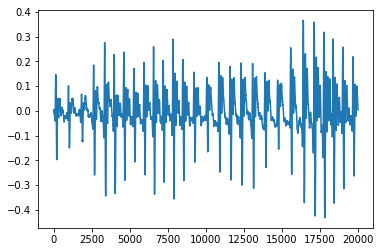

In [8]:
plt.plot(df.iloc[0:20000, 1])

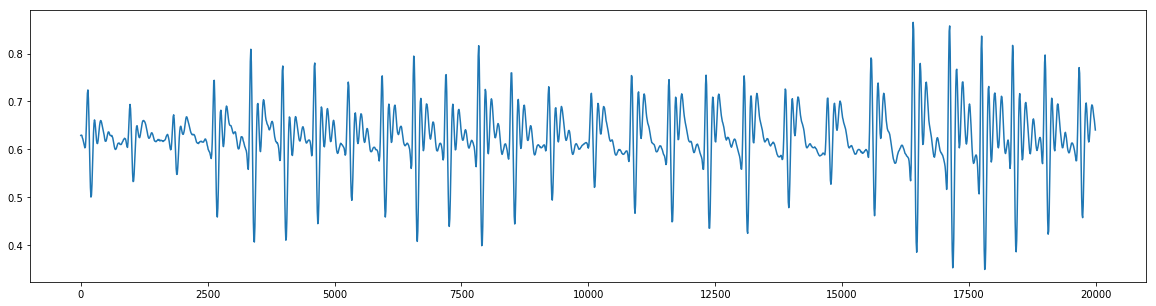

(4799800, 6)

In [9]:
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler((0,1))
mm.fit(df.iloc[:, 1].values.reshape(-1, 1))
df["scaledBuzz"] = mm.transform(df.iloc[:, 1].values.reshape(-1, 1))


subSamp = np.arange(0, 20000, step = 10)# np.arange(0, df.shape[0], step = 5)
plt.figure(figsize=(20,5))
plt.plot(np.array(df.index[subSamp]), np.array(df.iloc[subSamp,5]))
#plt.scatter(df.index[subSamp], df.iloc[subSamp,2]*10, s = 0.5, c = df.iloc[subSamp,3])
plt.show()
df.shape

In [10]:
print(df.shape)
subSamp = np.arange(0, df.shape[0], step = 10)# np.arange(0, df.shape[0], step = 5)
df = df.iloc[subSamp, :]
print(df.shape)

(4799800, 6)
(479980, 6)


In [11]:
# code from : https://gist.github.com/jkleint/1d878d0401b28b281eb75016ed29f2ee


# """
# Example of using Keras to implement a 1D convolutional neural network (CNN) for timeseries prediction.
# """

from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from keras.models import Sequential


def make_timeseries_regressor(window_size, filter_length, nb_input_series=1, nb_outputs=1, nb_filter=4):
    """:Return: a Keras Model for predicting the next value in a timeseries given a fixed-size lookback window of previous values.
    The model can handle multiple input timeseries (`nb_input_series`) and multiple prediction targets (`nb_outputs`).
    :param int window_size: The number of previous timeseries values to use as input features.  Also called lag or lookback.
    :param int nb_input_series: The number of input timeseries; 1 for a single timeseries.
      The `X` input to ``fit()`` should be an array of shape ``(n_instances, window_size, nb_input_series)``; each instance is
      a 2D array of shape ``(window_size, nb_input_series)``.  For example, for `window_size` = 3 and `nb_input_series` = 1 (a
      single timeseries), one instance could be ``[[0], [1], [2]]``. See ``make_timeseries_instances()``.
    :param int nb_outputs: The output dimension, often equal to the number of inputs.
      For each input instance (array with shape ``(window_size, nb_input_series)``), the output is a vector of size `nb_outputs`,
      usually the value(s) predicted to come after the last value in that input instance, i.e., the next value
      in the sequence. The `y` input to ``fit()`` should be an array of shape ``(n_instances, nb_outputs)``.
    :param int filter_length: the size (along the `window_size` dimension) of the sliding window that gets convolved with
      each position along each instance. The difference between 1D and 2D convolution is that a 1D filter's "height" is fixed
      to the number of input timeseries (its "width" being `filter_length`), and it can only slide along the window
      dimension.  This is useful as generally the input timeseries have no spatial/ordinal relationship, so it's not
      meaningful to look for patterns that are invariant with respect to subsets of the timeseries.
    :param int nb_filter: The number of different filters to learn (roughly, input patterns to recognize).
    """
    model = Sequential((
        # The first conv layer learns `nb_filter` filters (aka kernels), each of size ``(filter_length, nb_input_series)``.
        # Its output will have shape (None, window_size - filter_length + 1, nb_filter), i.e., for each position in
        # the input timeseries, the activation of each filter at that position.
        
        #Conv1D(activation="relu", filters=4, kernel_size=5)
        Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', input_shape=(window_size, nb_input_series)),
        MaxPooling1D(),     # Downsample the output of convolution by 2X.
        Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu'),
        MaxPooling1D(),
        Flatten(),
        Dense(nb_outputs, activation='sigmoid'),     # For binary classification, change the activation to 'sigmoid'
    ))
    #model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    # To perform (binary) classification instead:
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    return model


def make_timeseries_instances(timeseries, seqLabels, window_size):
    """Make input features and prediction targets from a `timeseries` for use in machine learning.
    :return: A tuple of `(X, y, q)`.  `X` are the inputs to a predictor, a 3D ndarray with shape
      ``(timeseries.shape[0] - window_size, window_size, timeseries.shape[1] or 1)``.  For each row of `X`, the
      corresponding row of `y` is the next value in the timeseries.  The `q` or query is the last instance, what you would use
      to predict a hypothetical next (unprovided) value in the `timeseries`.
    :param ndarray timeseries: Either a simple vector, or a matrix of shape ``(timestep, series_num)``, i.e., time is axis 0 (the
      row) and the series is axis 1 (the column).
    :param int window_size: The number of samples to use as input prediction features (also called the lag or lookback).
    """
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0]
    X = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size)]))
    y = seqLabels
    q = np.atleast_3d([timeseries[-window_size:]])
    return X, y, q


def evaluate_timeseries(timeseries, seqLabels, window_size, epochs=100):
    """Create a 1D CNN regressor to predict the next value in a `timeseries` using the preceding `window_size` elements
    as input features and evaluate its performance.
    :param ndarray timeseries: Timeseries data with time increasing down the rows (the leading dimension/axis).
    :param int window_size: The number of previous timeseries values to use to predict the next.
    """
    filter_length = 5
    nb_filter = 4
    timeseries = np.atleast_2d(timeseries)
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T       # Convert 1D vectors to 2D column vectors

    nb_samples, nb_series = timeseries.shape
    print('\n\nTimeseries ({} samples by {} series):\n'.format(nb_samples, nb_series), timeseries)
    model = make_timeseries_regressor(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series, nb_outputs=nb_series, nb_filter=nb_filter)
    print('\n\nModel with input size {}, output size {}, {} conv filters of length {}'.format(model.input_shape, model.output_shape, nb_filter, filter_length))
    model.summary()

    X, y, q = make_timeseries_instances(timeseries, seqLabels, window_size)
    print('\n\nInput features:', X, '\n\nOutput labels:', y, '\n\nQuery vector:', q, sep='\n')
    test_size = int(0.3 * nb_samples)           # In real life you'd want to use 0.2 - 0.5
    train_size = nb_samples - test_size
    X_train, X_test, y_train, y_test = X[:-test_size], X[-test_size:], y[:-(test_size + window_size)], y[train_size - window_size: -window_size]
    history= model.fit(X_train, y_train, epochs=epochs, batch_size=2000, validation_data=(X_test, y_test))

    pred = model.predict(X_test)
    return(pred, X_train, X_test, y_train, y_test, model, history)


C:\Users\calli\Anaconda3\envs\deeplearning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
timeseries = df.iloc[:, 5]
seqLabels = df.iloc[:, 3]

ts_length = df.shape[0]
window_size = 1000

print('\nSimple single timeseries vector prediction')
pred, X_train, X_test, y_train, y_test, model, history = evaluate_timeseries(timeseries,seqLabels, window_size, epochs = 20)



Simple single timeseries vector prediction


Timeseries (479980 samples by 1 series):
 [[0.62922798]
 [0.62986615]
 [0.62944071]
 ...
 [0.6284111 ]
 [0.6284111 ]
 [0.6284111 ]]
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


Model with input size (None, 1000, 1), output size (None, 1), 4 conv filters of length 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 996, 4)            24        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 498, 4)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 494, 4)            84        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 247, 4)            0         
______________________________________________________

In [13]:
#train for more epochs
history= model.fit(X_train, y_train, epochs=100, batch_size=2000, validation_data=(X_test, y_test))
pred = model.predict(X_test)

Train on 334986 samples, validate on 143994 samples
Epoch 1/100
334986/334986 [==============================] - 5s 16us/step - loss: 0.3297 - binary_accuracy: 0.8782 - val_loss: 0.3308 - val_binary_accuracy: 0.8817
Epoch 2/100
334986/334986 [==============================] - 5s 15us/step - loss: 0.3259 - binary_accuracy: 0.8796 - val_loss: 0.3293 - val_binary_accuracy: 0.8874
Epoch 3/100
334986/334986 [==============================] - 5s 15us/step - loss: 0.3232 - binary_accuracy: 0.8809 - val_loss: 0.3268 - val_binary_accuracy: 0.8865
Epoch 4/100
334986/334986 [==============================] - 5s 15us/step - loss: 0.3210 - binary_accuracy: 0.8822 - val_loss: 0.3265 - val_binary_accuracy: 0.8946
Epoch 5/100
334986/334986 [==============================] - 5s 15us/step - loss: 0.3164 - binary_accuracy: 0.8839 - val_loss: 0.3214 - val_binary_accuracy: 0.8937
Epoch 6/100
334986/334986 [==============================] - 5s 15us/step - loss: 0.3143 - binary_accuracy: 0.8850 - val_loss: 0

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])


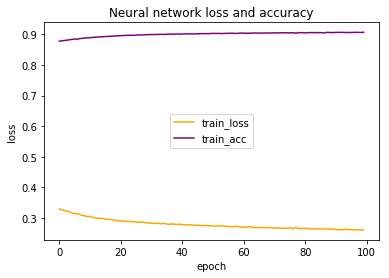

In [14]:
print(history.history.keys())


plt.plot(history.history['loss'], c = "orange")
plt.title('Neural network loss and accuracy')
plt.ylabel('loss')

plt.xlabel('epoch')




plt.plot(history.history['binary_accuracy'], c = "purple")
plt.legend(['train_loss', 'train_acc'], loc='center')


plt.show()

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(np.array(y_test)[0:50000], ((np.array(pred) > 0.5) * 1)[0:50000])

0.90878

In [16]:
X_train.shape
y_train.shape

(334986,)

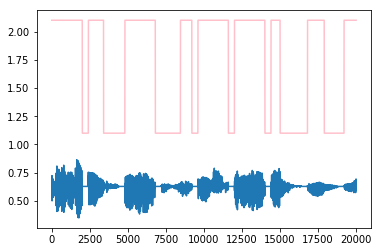

In [17]:
plt.plot(X_train[0:20000,0, -1])
plt.plot(np.array(y_train)[0:20000] + 1.1, c= 'pink')


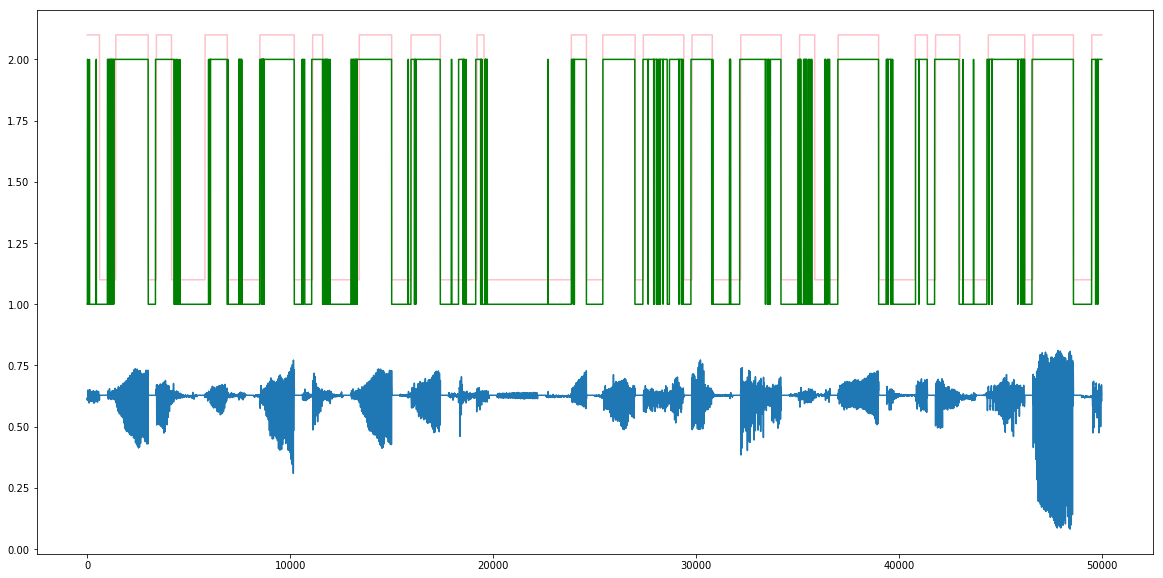

In [18]:

plt.figure(figsize=[20, 10])
plt.plot(X_test[0:50000,0, -1])
plt.plot(np.array(y_test)[0:50000] + 1.1, c= 'pink')
plt.plot(((np.array(pred) > 0.5) * 1)[0:50000] + 1, c= 'green')

In [19]:
X_test.shape

(143994, 1000, 1)


___

### 1D convolution on spectrogram 

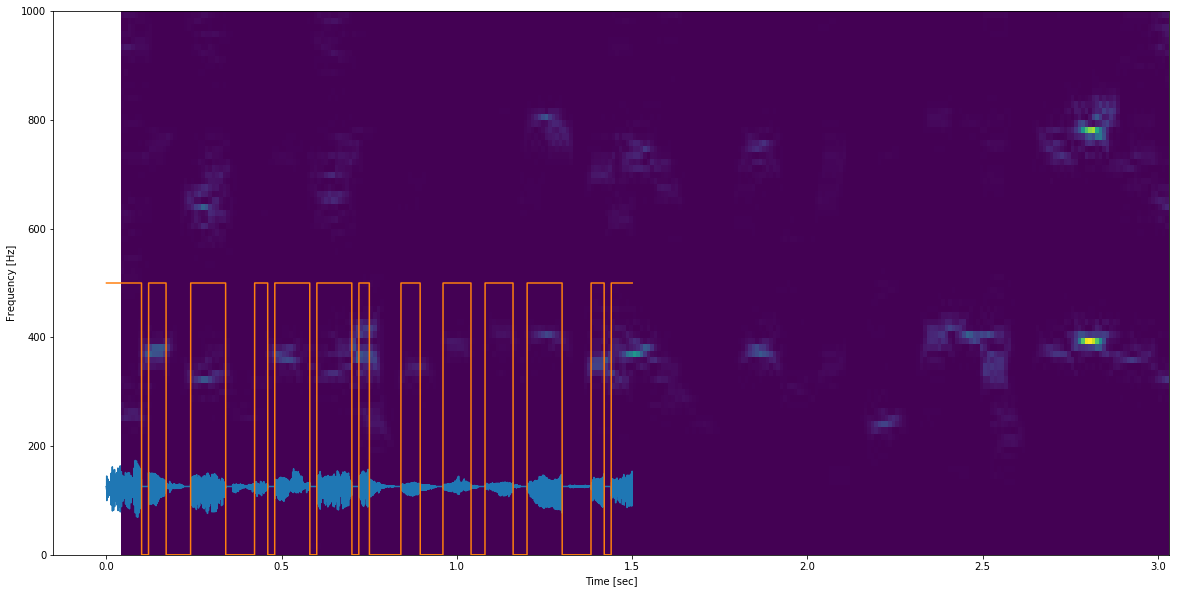

In [20]:
# add padding to beginning of dataset

df = pd.concat(bigList)
df.reset_index(drop = True, inplace = True)
mm = MinMaxScaler((0,1))
mm.fit(df.iloc[:, 1].values.reshape(-1, 1))
df["scaledBuzz"] = mm.transform(df.iloc[:, 1].values.reshape(-1, 1))

seq = df.loc[:,"scaledBuzz"]

# timesteps = np.linspace(0, 2, num = 2000000)
# freq = ((np.sin(timesteps*timesteps/2*10*2*np.pi) + 1)**3 > 4 ) + 0.3
# seq = np.sin((freq*100 * timesteps) * 2 * np.pi)
# plt.plot(timesteps, seq)
# plt.plot(timesteps, freq + 1)

from scipy import signal
plt.figure(figsize=[20, 10])
f, t, Sxx = signal.spectrogram(np.array(seq), 200000, noverlap = 15000, nperseg = 17000)
Sxx = Sxx[0:90]
f = f[0:90]
plt.pcolormesh(t[0:300], f, Sxx[:, 0:300])
plt.ylim(0,1000)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')


x2 = (np.arange(df.shape[0]) / 200000)
y2 = df.loc[:,"scaledBuzz"]
y3 = df.buzz * 500
plt.plot(x2[x2 < 1.5], y2[x2 < 1.5]*200)
plt.plot(x2[x2 < 1.5], y3[x2 < 1.5])


400000
1.96


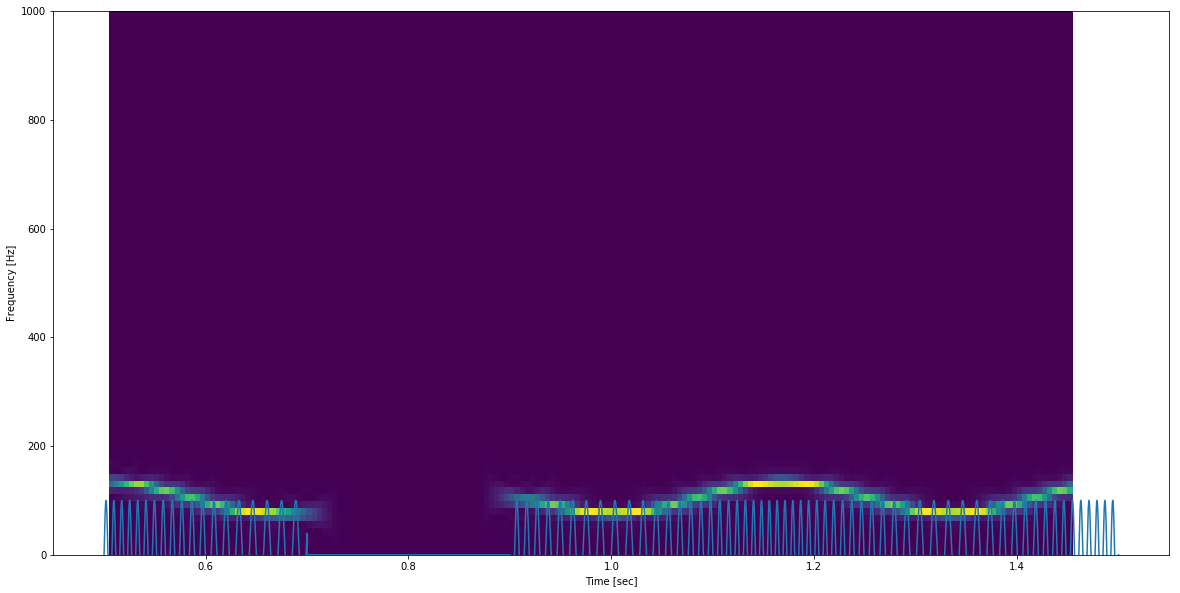

In [21]:
# signal practice
samplingFreq = 200000

xx = np.linspace(0, 1, num = samplingFreq)
seq = np.sin(100 * 2 * np.pi * xx + (10*np.sin(2*np.pi* 3 * xx))) #+ np.sin(800*2*np.pi* xx)

seq[40000:80000] = 0

# add padding
padLength = 100000
s2 = np.hstack([np.zeros(padLength),seq,np.zeros(padLength)])
print(len(s2))
# timesteps = np.linspace(0, 2, num = 2000000)
# freq = ((np.sin(timesteps*timesteps/2*10*2*np.pi) + 1)**3 > 4 ) + 0.3
# seq = np.sin((freq*100 * timesteps) * 2 * np.pi)
# plt.plot(timesteps, seq)
# plt.plot(timesteps, freq + 1)

from scipy import signal
plt.figure(figsize=[20, 10])
nperS = 16000
f, t, Sxx = signal.spectrogram(np.array(s2), 200000, noverlap = 15000, nperseg = nperS)
Sxx = Sxx[0:90, (t > (padLength / samplingFreq)) & (t <( np.max(t)- (padLength / samplingFreq)))]
f = f[0:90]
print(np.max(t))
t = t[(t > (padLength / samplingFreq)) & (t <( np.max(t)- (padLength / samplingFreq)))]
plt.pcolormesh(t[0:300], f, Sxx[:, 0:300])
plt.ylim(0,1000)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')





plt.plot(xx + (padLength / samplingFreq), (seq*100))



# now resize to fit original data



In [ ]:
# signal practice
samplingFreq = 200000

xx = np.linspace(0, 1, num = samplingFreq)
seq = np.sin(100 * 2 * np.pi * xx + (10*np.sin(2*np.pi* 3 * xx))) #+ np.sin(800*2*np.pi* xx)

seq[40000:80000] = 0

from scipy import signal
plt.figure(figsize=[20, 10])
nperS = 16000
f, t, Sxx = signal.spectrogram(np.array(seq), 200000, noverlap = 1550, nperseg = nperS)
Sxx = Sxx[0:90,:]
f = f[0:90]
plt.pcolormesh(t, f, Sxx)
plt.ylim(0,1000)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')





plt.plot(xx , (seq*100))


# now resize to fit original data
plt.plot(t, Sxx[15, :]*10000000)
print(np.min(t), np.max(t))


In [ ]:
pd.DataFrame(np.transpose([t, Sxx[20, :]*100]))
min(t), max(t)

In [ ]:
FS = pd.concat(freqSpec)
plt.imshow((FS.transpose()).iloc[:,  0:500, ], aspect = "auto", origin = 'lower')

In [ ]:
subSamp = np.linspace(0, df.shape[0]-1, num = t.shape[0]).astype(int)

In [ ]:
df2 = df.iloc[subSamp, :]

In [ ]:
plt.plot(x2[x2 < 2.5], y2[x2 < 2.5]*300)

x2 = (np.arange() / 20000)
y2 = df2.loc[:,"scaledBuzz"]
plt.plot(x2[x2 < 2.5], y2[x2 < 2.5])